<a href="https://colab.research.google.com/github/textnorms/date_text_norm/blob/master/T5_V10_(En_dates).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
! nvidia-smi

Mon Jun  1 18:35:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [36]:
! rm -rf date*
! git clone https://github.com/textnorms/date_text_norm.git
! cp -r date_text_norm/syntetic_data_En/ .
! cp -r date_text_norm/syntetic_data_Pt/ .

! pip install -q num2words transformers
! pip install -q transformers

Cloning into 'date_text_norm'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 160 (delta 90), reused 65 (delta 27), pack-reused 0
Receiving objects: 100% (160/160), 643.68 KiB | 1.86 MiB/s, done.
Resolving deltas: 100% (90/90), done.


# Libs

In [0]:
# Basics
import numpy as np
import pandas as pd
import random

# Synthetic data generator
from syntetic_data_En import DateTextGenerator as DatesEnglish
from syntetic_data_Pt import DateTextGenerator as DatesPortuguese

# PyTorch
import torch 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# Transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

# Matplot lib
import matplotlib.pyplot as plt

### Deterministic experiments

In [3]:
manual_seed = 2357 # only primes, cuz I like
def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Deterministic experiment, seed: {manual_seed}')
    else:
        print('Random experiment')

deterministic()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Deterministic experiment, seed: 2357
Using device: cuda


# Config constants

In [0]:
# Model params
MODEL_SZ = 't5-small' # 't5-base'
TOK = T5Tokenizer.from_pretrained(MODEL_SZ)
MAX_LEN_SRC  = 48
MAX_LEN_TRGT = 12

# Train params
BATCH_SZ = 16
N_EPOCHS = 3
WINDOW   = 7

# Dataset

In [39]:
pd.set_option('display.max_rows',50)

datas_En = DatesEnglish(start_date='01/01/1921',
                        end_date='31/12/2120',
                        text_noise_rate=0.3)

datas_Pt = DatesPortuguese(start_date='01/01/1921',
                           end_date='31/12/2120',
                           text_noise_rate=0.3)

examples = datas_En.generate_demo(date='4/11/1983'); examples

,Input Pattern,Generated Text,Origin Sample
0,1,four of november of 1983,4/11/1983
1,2,"four of nov of one thousand, nine hundred and ...",4/11/1983
2,3,"four of november of one thousand, nine hundred...",4/11/1983
3,4,"fourth day of month eleven of one thousand, ni...",4/11/1983
4,5,4 of November of 1983,4/11/1983
5,6,"4 of november of one thousand, nine hundred an...",4/11/1983
6,7,"4-11 of one thousand, nine hundred and eighty-...",4/11/1983
7,8,four - 11 - 1983,4/11/1983
8,9,four of november - 1983,4/11/1983
9,10,4th of november of 1983,4/11/1983


In [40]:
df_En = datas_En.generate_date_dataset() 
df_Pt = datas_Pt.generate_date_dataset() 
f'df_En: {df_En.shape} -- df_Pt: {df_Pt.shape}'

'df_En: (73049, 4) -- df_Pt: (73049, 4)'

## Portuguese Dataset

In [46]:
df_Pt.tail()

,Input Pattern,Noise Type,Input,Target
73044,39,N/A,27 / 12 / 2120,27/12/2120
73045,10,"[lookalike_replace_noise, remove_char_noise, u...",28º de dez enbr0 d 2120,28/12/2120
73046,40,"[remove_char_noise, lookalike_replace_noise]",29/deenbro/212o,29/12/2120
73047,14,N/A,30 / dezembro / 2120,30/12/2120
73048,20,"[unexpected_space_noise, remove_char_noise, lo...","trita e vm/dezembro /dois mll, ceno e vint e",31/12/2120


# English Dataset

In [47]:
df_En.tail()

,Input Pattern,Noise Type,Input,Target
73044,39,"[lookalike_replace_noise, unexpected_space_noi...",27 / 12 / 2 12o,27/12/2120
73045,44,"[unexpected_space_noise, remove_char_noise, lo...",28 /12/12o,28/12/2120
73046,37,[lookalike_replace_noise],29 . dec . 212o,29/12/2120
73047,6,N/A,"30 of december of two thousand, one hundred an...",30/12/2120
73048,43,N/A,31 / dec / 2120,31/12/2120


## Function to split the dataset

In [48]:
def split_data(df, test_size=0.2, verbose=True):
    l = list(set(df['Input Pattern'].values))
    num_test = int(len(l)*test_size)
    test_methods = [random.randint(1, len(l)) for _ in range(num_test)]
    
    df_test = df[df['Input Pattern'].isin(test_methods)]
    x_test = df_test.Input.values
    y_test = df_test.Target.values

    df_train = df[~df['Input Pattern'].isin(test_methods)]

    x_train, x_val, y_train, y_val = train_test_split(
        df_train.Input.values,
        df_train.Target.values,
        shuffle=True, 
        test_size=test_size,
        random_state=manual_seed
        )
    if verbose:
        print(f'Date types of test set: {test_methods} with len: {len(test_methods)}')
        print(f'x_train: {len(x_train)}  --  y_train: {len(y_train)}\n\
x_val:   {len(x_val)}  --  y_val:   {len(y_val)}\n\
x_test:  {len(x_test)}  --  y_test:  {len(y_test)}')

    return x_train, y_train, x_val, y_val, x_test, y_test

# creating sets
x_train, y_train, x_val, y_val, x_test, y_test = split_data(df_En, 
                                                            test_size=0.25, 
                                                            verbose=True)

Date types of test set: [17, 27, 23, 31, 36, 1, 40, 34, 30, 40, 6] with len: 11
x_train: 42703  --  y_train: 42703
x_val:   14235  --  y_val:   14235
x_test:  16111  --  y_test:  16111


In [0]:
class DateDataset(Dataset):
    def __init__(self, data, label, tokenizer, source_max_length, target_max_length):
        self.tokenizer = tokenizer
        self.data = data
        self.label = label
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        source = self.data[idx]
        target = self.label[idx]

        source_tokenized = self.tokenizer.encode_plus(
            f'{source} {self.tokenizer.eos_token}',
            max_length=self.source_max_length,
            pad_to_max_length=True,
            return_tensors='pt')

        target_tokenized = self.tokenizer.encode_plus(
            f'{target} {self.tokenizer.eos_token}',
            max_length=self.target_max_length,
            pad_to_max_length=True,
            return_tensors='pt')

        source_token_ids = source_tokenized['input_ids'].squeeze()
        source_mask = source_tokenized['attention_mask'].squeeze()
        target_token_ids = target_tokenized['input_ids'].squeeze()
        
        return source_token_ids, source_mask, target_token_ids

## Checking the DateDataset class

In [16]:
dataset_debug = DateDataset(
    x_train, 
    y_train,
    TOK,
    MAX_LEN_SRC,
    MAX_LEN_TRGT,
    )

dataloader_checking = DataLoader(
    dataset_debug, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0
    )

source_token_ids, source_mask, target_token_ids = next(iter(dataloader_checking))
print(f'source_token_ids:\n {source_token_ids} --- shape:{source_token_ids.shape}')
print(f'source_mask:\n {source_mask} --- shape:{source_mask.shape}')
print(f'target_token_ids:\n {target_token_ids} --- shape:{target_token_ids.shape}')

source_token_ids:
 tensor([[ 1401,    18,   221,    75,    18, 22224,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]]) --- shape:torch.Size([1, 48])
source_mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) --- shape:torch.Size([1, 48])
target_token_ids:
 tensor([[ 1401, 18009,    87, 22224,     1,     0,     0,     0,     0,     0,
             0,     0]]) --- shape:torch.Size([1, 12])


## Datasets e Dataloaders

In [17]:
# datasets
ds_debug = DateDataset(x_train[:BATCH_SZ], y_train[:BATCH_SZ], TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_train = DateDataset(x_train, y_train, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_valid = DateDataset(x_val, y_val, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_test  = DateDataset(x_test, y_test, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)

print('Datasets len:')
print(f'len ds_debug: {len(ds_debug)}')
print(f'len ds_train: {len(ds_train)}')
print(f'len ds_valid: {len(ds_valid)}')
print(f'len ds_test:  {len(ds_test)}')

# dataloaders
dataloaders = {
    'debug': DataLoader(
         ds_debug,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=2,
         pin_memory=True),
    'train': DataLoader(
         ds_train,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=2,
         pin_memory=True),
    'valid': DataLoader(
         ds_valid,
         batch_size=BATCH_SZ,
         shuffle=False,
         num_workers=2,
         pin_memory=True),
    'test': DataLoader(
         ds_test,
         batch_size=BATCH_SZ,
         shuffle=False,
         num_workers=2,
         pin_memory=True),
               }
# sanity check
print('\nDataloaders len (in batch):')
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}; dl_sizes

Datasets len:
len ds_debug: 16
len ds_train: 42570
len ds_valid: 14191
len ds_test:  16288

Dataloaders len (in batch):


{'debug': 1, 'test': 1018, 'train': 2661, 'valid': 887}

In [0]:
# testando o dataloader 
source_token_ids, source_mask, target_token_ids = next(iter(dataloaders['debug']))

In [0]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_SZ)
    
    def forward(self, token_ids, att_mask, labels):
        outputs = self.model.forward(
            input_ids=token_ids, 
            attention_mask=att_mask,
            lm_labels=labels
            )
        return outputs[0] # loss
    
    @torch.no_grad()    
    def generate(self, token_ids, att_mask, max_len_target):
        predict = self.model.generate(
            input_ids=token_ids, 
            attention_mask=att_mask,
            max_length=max_len_target
            )
        return predict
    
    @torch.no_grad()  
    def generate_example(self, text_input, tokenizer, max_len_source=MAX_LEN_SRC):

        self.model.eval()
        
        example_tokenized = tokenizer.encode_plus(
            f'{text_input} {tokenizer.eos_token}',
            max_length=max_len_source,
            pad_to_max_length=True,
            return_tensors='pt')
            
        example_token_ids = example_tokenized['input_ids']
        example_mask = example_tokenized['attention_mask']

        predicted_example = self.model.generate(
            input_ids=example_token_ids.to(device), 
            attention_mask=example_mask.to(device),
            max_length=MAX_LEN_TRGT
            )

        self.model.train()

        out_text = [tokenizer.decode(text) for text in predicted_example]
        
        return out_text

## Train and evaluation functions

In [0]:
# acc metric for text inputs
def acc_in_text(trues, preds): 
    acc = []
    for d in zip(trues, preds):
        if d[0] == d[1]:
            acc.append(1)
        else:
            acc.append(0)
    return acc # bool

def train(model, device, train_loader, optimizer):
    loss_train = []
    model.train()
    for source_token_ids, source_mask, target_token_ids in train_loader:
        optimizer.zero_grad()
        loss = model(
            source_token_ids.to(device), 
            source_mask.to(device), 
            target_token_ids.to(device)
            )
        
        loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
    
    train_losses = sum(loss_train) / len(loss_train)
  
    return train_losses

def evaluate_fn(model, device, val_loader, max_len=MAX_LEN_TRGT):
    loss_val, all_acc, all_preds, all_trues = [], [], [], []
    model.eval()
    for source_token_ids, source_mask, target_token_ids in val_loader:
        predicted_ids = model.generate(
            source_token_ids.to(device), 
            source_mask.to(device),
            max_len
            )
        
        preds = [TOK.decode(t) for t in predicted_ids]
        trues = [TOK.decode(t) for t in target_token_ids]
        acc = acc_in_text(trues, preds)
        all_acc.extend(acc)
        all_trues.extend(trues)
        all_preds.extend(preds)
        
        # val loss   
        loss = model(
        source_token_ids.to(device), 
        source_mask.to(device), 
        target_token_ids.to(device)
        )
        loss_val.append(loss.item())
    
    val_losses = sum(loss_val) / len(loss_val)
    
    return val_losses, np.array(all_acc).mean(), all_trues, all_preds

# Overfit in one batch 
- dataloader debug

In [0]:
overfit = False

if overfit:

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    deterministic() 

    model = Net().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    
    # -----------------------------------------------------------------------------
    start.record()
    for step in range(1, 1001):
        samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
        loss_t = train(model, device, dataloaders['debug'], optimizer)
        acc, trues, preds = evaluate_fn(model, device, dataloaders['debug'])
        if step == 1:
            print(f'[Epoch: {step}/{1000}] |', end=' ')
            print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
        if step % 100 == 0:
            print(f'[Epoch: {step}/{1000}] |', end=' ')
            print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
            print(f'  Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')
    end.record()
    torch.cuda.synchronize()    
    # -----------------------------------------------------------------------------

    print(f'Training time: {start.elapsed_time(end)/1000/60 :.3f} min.')
    del model

# Training 

In [22]:
# del model
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
deterministic() 

model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# ---------------------------------------------------------------------------------
start.record()
for step in range(1, N_EPOCHS+1):
    samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
    loss_t = train(model, device, dataloaders['train'], optimizer)
    loss_v, acc, trues, preds = evaluate_fn(model, device, dataloaders['valid'])
    print(f'[Epoch: {step}/{N_EPOCHS}] |', end=' ')
    print(f'Train Loss: {loss_t:.3f} -- Valid Loss: {loss_v:.3f} -- Acc: {acc:.3f}')
    print(f'  Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')

end.record()
torch.cuda.synchronize()    
# ---------------------------------------------------------------------------------

print(f'Training time: {start.elapsed_time(end)/1000/60 :.3f} min.')

Deterministic experiment, seed: 2357



[Epoch: 1/3] | Train Loss: 0.357 -- Valid Loss: 0.080 -- Acc: 0.827
  Trues: ['24/08/2081', '07/09/1944', '13/11/2000', '13/04/2078', '30/05/1939', '17/08/1969', '19/04/1971']
  Preds: ['24/08/2111', '07/09/1994', '13/11/2050', '13/04/2078', '30/05/1939', '06/08/1969', '19/04/1971']
[Epoch: 2/3] | Train Loss: 0.095 -- Valid Loss: 0.051 -- Acc: 0.888
  Trues: ['29/11/2114', '24/08/2081', '07/09/1944', '13/11/2000', '13/04/2078', '30/05/1939', '17/08/1969']
  Preds: ['29/11/2114', '24/08/2001', '07/09/1994', '13/11/2000', '13/04/2078', '30/05/1939', '06/08/1969']
[Epoch: 3/3] | Train Loss: 0.065 -- Valid Loss: 0.038 -- Acc: 0.908
  Trues: ['15/02/2117', '10/01/2055', '01/02/2069', '23/08/1983', '17/11/2036', '02/06/1947', '29/11/2114']
  Preds: ['15/02/2117', '10/01/2055', '01/02/2069', '23/08/1983', '17/11/2036', '02/06/1947', '29/11/2114']
Training time: 16.073 min.


# Test

In [23]:
# ---------------------------------------------------------------------------------
start.record()

samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
loss, acc, trues, preds = evaluate_fn(model, device, dataloaders['test'])
print(f'Loss: {loss:.3f} -- Acc: {acc:.3f}')
print(f' Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')

end.record()
torch.cuda.synchronize()    
# ---------------------------------------------------------------------------------

print(f'Test time: {start.elapsed_time(end)/1000/60 :.3f} min.')

Loss: 0.046 -- Acc: 0.888
 Trues: ['16/01/1921', '21/01/1921', '28/01/1921', '01/02/1921', '02/02/1921', '04/02/1921', '06/02/1921']
  Preds: ['16/01/1921', '21/01/1921', '28/01/1921', '01/02/1921', '02/02/1921', '04/02/1921', '02/02/1921']
Test time: 1.663 min.


# Evaluating types for a same date

Given a sample date, this section evaluates wich is the accuracy.




In [0]:
def evaluate_for_a_same_date(date,model=model,tokenizer=TOK,verbose=True):
  '''
    Given a specific date, returns the accuracy in all evalueated types.
    Also prints results per sample.
  '''

  results = []
  
  examples = datas.generate_demo(date=date)

  for x,target in zip(examples['Generated Text'],examples['Origin Sample']):

    prediction = model.generate_example(x,TOK)[0]

    results.append(prediction == target)

    if verbose:
      print(f'Entrada: {x} -- Target: {target} --- Previsto: {prediction} --- {prediction == target}')


  if verbose:
    print(f'Total accuracy: {np.mean(results)}')

  return np.mean(results)


In [25]:
'''
  A date in the century with more dates occuring
'''

evaluate_for_a_same_date('11/07/1988')

Entrada: eleven of july of 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: eleven of jul of one thousand, nine hundred and eighty-eight -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: eleven of july of one thousand, nine hundred and eighty-eight -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: eleventh day of month seven of one thousand, nine hundred and eighty-eight -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11 of July of 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11 of july of one thousand, nine hundred and eighty-eight -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11-07 of one thousand, nine hundred and eighty-eight -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: eleven - 07 - 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: eleven of july - 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11th of july o

1.0

In [26]:
'''
  A date in a century with less dates occurring, but that is inside the
  generated dataset
'''

evaluate_for_a_same_date('20/12/2015')

Entrada: twenty of december of 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: twenty of dec of two thousand and fifteen -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: twenty of december of two thousand and fifteen -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: twentieth day of month twelve of two thousand and fifteen -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20 of December of 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20 of december of two thousand and fifteen -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20-12 of two thousand and fifteen -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: twenty - 12 - 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: twenty of december - 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20th of december of 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrad

1.0

In [27]:
'''
  Evaluating for a date in a century out of the training range gives the worst
  acc possible. (0)
'''
evaluate_for_a_same_date('25/12/2141')

Entrada: twenty-five of december of 2141 -- Target: 25/12/2141 --- Previsto: 25/12/241 --- False
Entrada: twenty-five of dec of two thousand, one hundred and forty-one -- Target: 25/12/2141 --- Previsto: 25/12/241 --- False
Entrada: twenty-five of december of two thousand, one hundred and forty-one -- Target: 25/12/2141 --- Previsto: 25/12/241 --- False
Entrada: twenty-fifth day of month twelve of two thousand, one hundred and forty-one -- Target: 25/12/2141 --- Previsto: 25/12/241 --- False
Entrada: 25 of December of 2141 -- Target: 25/12/2141 --- Previsto: 25/12/241 --- False
Entrada: 25 of december of two thousand, one hundred and forty-one -- Target: 25/12/2141 --- Previsto: 25/12/2101 --- False
Entrada: 25-12 of two thousand, one hundred and forty-one -- Target: 25/12/2141 --- Previsto: 25/12/2101 --- False
Entrada: twenty-five - 12 - 2141 -- Target: 25/12/2141 --- Previsto: 25/12/241 --- False
Entrada: twenty-five of december - 2141 -- Target: 25/12/2141 --- Previsto: 25/12/241 -

0.2

In [28]:
'''
  An earlier date than the beggining of the generated dataset
'''

evaluate_for_a_same_date('27/05/1920')

Entrada: twenty-seven of may of 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: twenty-seven of may of one thousand, nine hundred and twenty -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: twenty-seven of may of one thousand, nine hundred and twenty -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: twenty-seventh day of month five of one thousand, nine hundred and twenty -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: 27 of May of 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: 27 of may of one thousand, nine hundred and twenty -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: 27-05 of one thousand, nine hundred and twenty -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: twenty-seven - 05 - 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: twenty-seven of may - 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: 27th of may of

0.9333333333333333

# Accuracy in dataset dates

## Inside dataset

Dates into the interval that was used to built the synthetic dataset used for test and eval.

In [29]:
accs = []
dates = []

sampled_test = random.sample(list(df['Target'].values),50)

print('acc test set: ',sampled_test)

for date_sample in sampled_test:
  accs.append(evaluate_for_a_same_date(date_sample,verbose=False))
  dates.append(date_sample)
  

acc test set:  ['30/12/2069', '16/11/2043', '29/11/2118', '21/09/1973', '23/08/2036', '02/03/1982', '06/09/1930', '23/02/2106', '23/10/2097', '24/04/2050', '12/07/1941', '15/07/1943', '07/03/1941', '26/06/1992', '16/04/2070', '11/10/1923', '28/02/2061', '28/10/1961', '26/04/2043', '31/08/2017', '03/03/2085', '27/12/2023', '22/03/2087', '21/04/2098', '19/01/1958', '11/07/2028', '19/03/1971', '16/08/2076', '16/03/1945', '26/05/1964', '16/04/2050', '09/01/1999', '14/02/1959', '23/01/2075', '21/08/1923', '26/07/1926', '14/07/1997', '10/06/2095', '12/03/2027', '04/02/2005', '04/08/1989', '23/08/1925', '23/06/1961', '07/09/2059', '02/01/2085', '08/04/2049', '08/06/1949', '21/08/2087', '04/06/2065', '30/05/1924']


Average of average accuracies:  0.9986666666666667


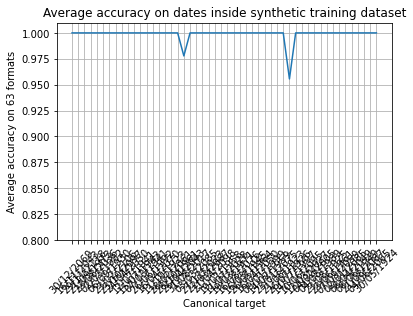

In [30]:
plt.plot(dates,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([0.8, 1.01])
plt.ylabel('Average accuracy on 63 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates inside synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

## Below dataset

Dates lower than the synthetic dataset used for test and eval.

In [32]:
accs = []
dates = []

new_dataset = DateTextGenerator('01/01/1900','31/12/1920')

new_df = new_dataset.generate_date_dataset()
sampled_test = random.sample(list(new_df['Target'].values),50)

print('acc test set: ',sampled_test)

for date_sample in sampled_test:
  accs.append(evaluate_for_a_same_date(date_sample,verbose=False))
  dates.append(date_sample)
  

acc test set:  ['02/01/1918', '14/07/1911', '13/04/1907', '19/03/1910', '24/09/1901', '26/04/1917', '21/05/1901', '09/01/1913', '10/06/1919', '05/11/1907', '15/07/1911', '08/04/1920', '20/04/1917', '14/05/1917', '01/07/1905', '20/02/1901', '09/03/1907', '10/05/1920', '28/10/1914', '15/06/1913', '29/04/1905', '24/11/1900', '08/06/1910', '02/10/1911', '15/07/1905', '07/07/1912', '31/10/1904', '17/06/1902', '05/02/1910', '04/02/1906', '18/02/1915', '27/04/1912', '13/08/1915', '15/10/1916', '15/01/1917', '02/01/1912', '26/01/1912', '18/01/1901', '20/10/1910', '09/03/1906', '29/09/1918', '06/05/1915', '24/12/1902', '02/11/1914', '26/08/1916', '28/03/1910', '27/07/1900', '28/08/1901', '03/12/1902', '21/09/1904']


Average of average accuracies:  0.8026666666666665


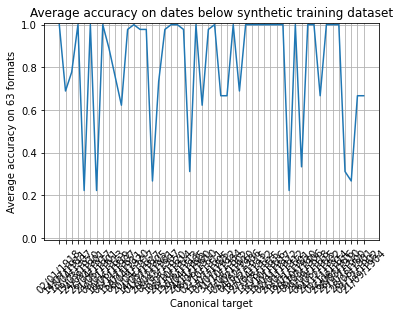

In [33]:
plt.plot(dates,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([-0.01, 1.01])
plt.ylabel('Average accuracy on 63 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates below synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

## Above dataset

Dates greater than the synthetic dataset used for test and eval.

In [34]:
accs = []
dates = []

new_dataset = DateTextGenerator('01/01/2121','31/12/2140')

new_df = new_dataset.generate_date_dataset()
sampled_test = random.sample(list(new_df['Target'].values),50)

print('acc test set: ',sampled_test)

for date_sample in sampled_test:
  accs.append(evaluate_for_a_same_date(date_sample,verbose=False))
  dates.append(date_sample)
  

acc test set:  ['15/12/2126', '19/11/2121', '27/01/2128', '21/11/2134', '11/07/2127', '13/11/2126', '10/07/2137', '30/10/2130', '27/06/2124', '18/05/2132', '02/05/2136', '07/07/2135', '07/06/2124', '20/10/2137', '25/05/2128', '25/06/2134', '10/04/2137', '12/08/2140', '16/12/2122', '30/07/2129', '12/11/2133', '09/02/2129', '27/05/2121', '02/04/2135', '10/03/2131', '23/03/2134', '12/10/2124', '12/03/2135', '26/12/2134', '20/08/2138', '19/08/2130', '19/09/2140', '13/02/2127', '28/08/2122', '12/10/2121', '03/02/2132', '10/07/2135', '02/11/2136', '09/03/2126', '18/11/2132', '15/06/2123', '29/01/2139', '24/06/2129', '18/10/2140', '10/12/2132', '21/11/2131', '14/07/2139', '12/11/2124', '01/04/2136', '14/08/2137']


Average of average accuracies:  0.5893333333333333


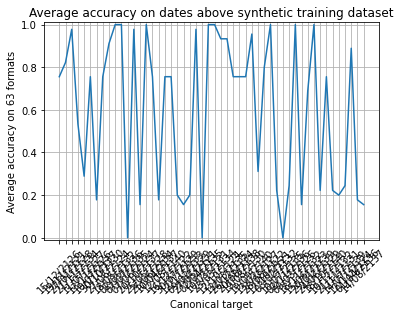

In [35]:
plt.plot(dates,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([-0.01, 1.01])
plt.ylabel('Average accuracy on 63 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates above synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

# The End